In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# gsw oceanic toolbox: http://www.teos-10.org/pubs/Getting_Started.pdf
import gsw
from scipy.io import loadmat
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import tqdm
import sys
import os
sys.path.append('../..')
from src.features.processing_func import mld
from src.features.processing_func import check_coords, calc_N2_kappa, calc_hab, arctic_calchab, calc_N2_kappa_sorted, mld
from src.features.calc_seaice import calc_SIC
from src.utils.directories import get_parent_directory
from src.features.feature_generation import processing_functions

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
parent_dir = get_parent_directory()

## Visualise this non na dataframe

In [3]:
full_df = pd.read_pickle(os.path.join(parent_dir, "data/processed/ml_ready/1406_ML.pkl"))
# full_df = pd.read_pickle("/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed/ml_ready/1406_ML.pkl")
full_df.cruise.unique()

array(['NICE-2015', 'ArcticMix', 'Mosaic', 'Haakon Mosby', 'ASBO',
       'IPY Barneo 2007', 'IPY Barneo 2008', 'Nansen Legacy 2018',
       'Nansen Legacy 2019', 'ASCOS'], dtype=object)

In [4]:
# Filter for unique latitude points
profile_df = full_df["latitude"].unique()

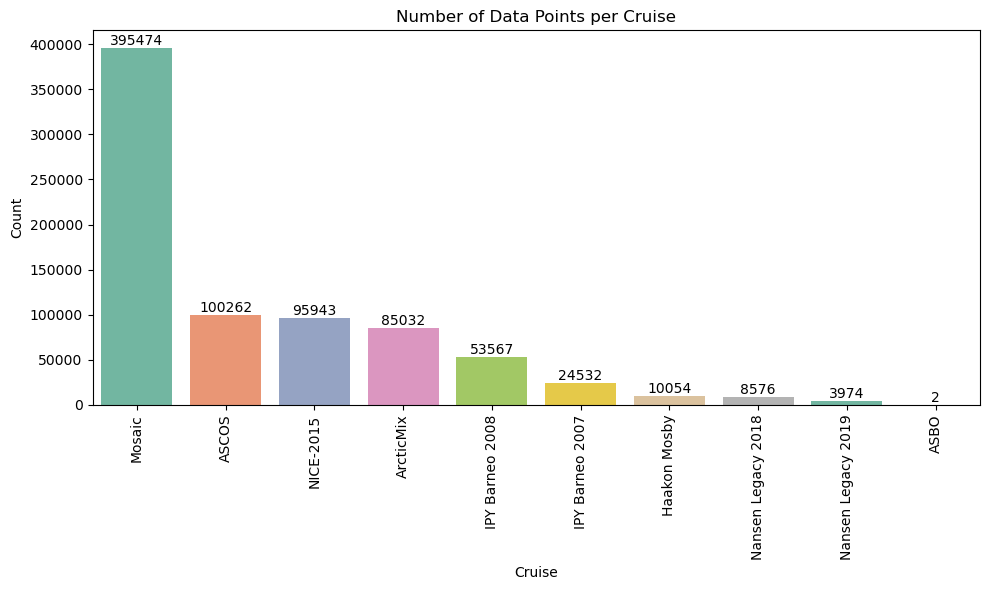

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the data points for each cruise
cruise_counts = full_df["cruise"].value_counts()

# Set a custom color palette
colors = sns.color_palette('Set2')

# Plot the cruise counts with custom colors
plt.figure(figsize=(10, 6))
sns.barplot(x=cruise_counts.index, y=cruise_counts.values, palette=colors)
plt.xlabel('Cruise')
plt.ylabel('Count')
plt.title('Number of Data Points per Cruise')

# Add count labels on top of each bar
for i, count in enumerate(cruise_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

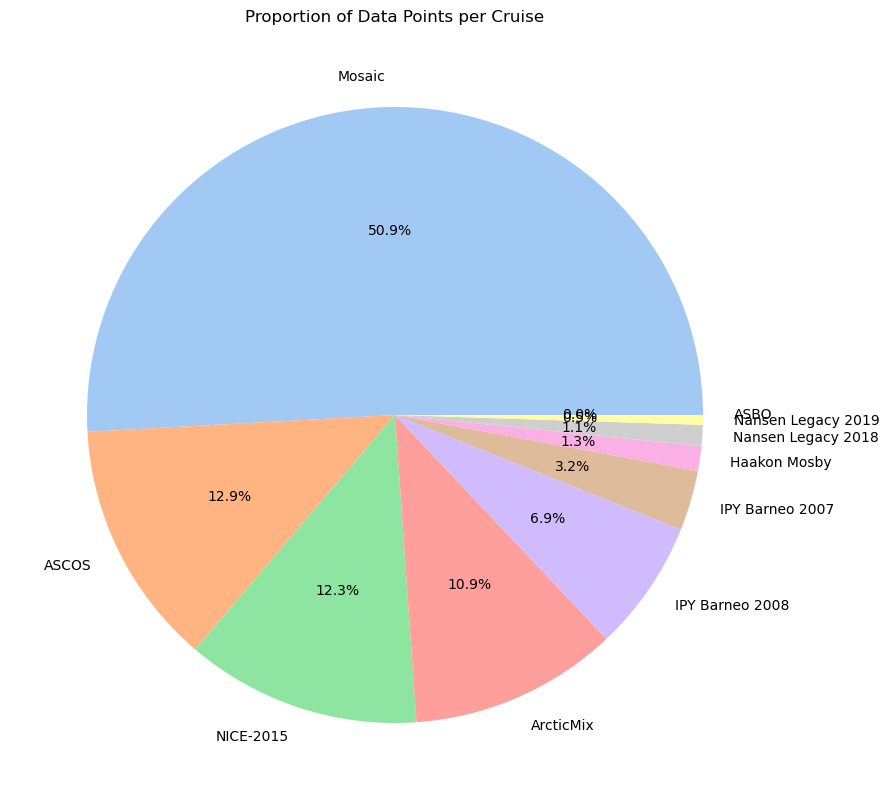

In [12]:
import seaborn as sns
# Calculate the proportions of data points for each cruise
cruise_proportions = full_df["cruise"].value_counts(normalize=True)

# Create a pie chart using Matplotlib with a Seaborn color palette
plt.figure(figsize=(10, 10))
colors = sns.color_palette("pastel")
plt.pie(cruise_proportions, labels=cruise_proportions.index, autopct='%1.1f%%', colors=colors)
plt.title('Proportion of Data Points per Cruise')
plt.show()

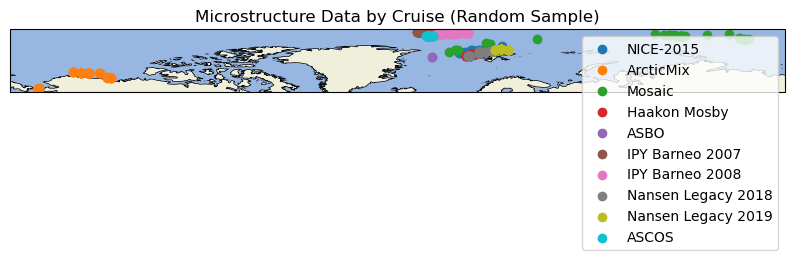

In [16]:
import random
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define the number of points to sample per cruise
num_points_per_cruise = 30

# Create an empty DataFrame to store the sampled data
sampled_data = pd.DataFrame()

# Iterate over each unique cruise
for cruise in full_df["cruise"].unique():
    cruise_data = full_df[full_df["cruise"] == cruise]
    
    # Check if the number of data points is less than the desired sample size
    if len(cruise_data) < num_points_per_cruise:
        # If fewer points, include all data points
        sampled_data = pd.concat([sampled_data, cruise_data])
    else:
        # If enough points, randomly sample the desired number
        sampled_data = pd.concat([sampled_data, cruise_data.sample(n=num_points_per_cruise, random_state=42)])

# Define a color palette for each cruise
cruise_palette = plt.cm.tab10(range(len(full_df["cruise"].unique())))

# Define the projection
projection = ccrs.PlateCarree()

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': projection})

# Add land and ocean features
ax.add_feature(cfeature.LAND, edgecolor='k')
ax.add_feature(cfeature.OCEAN)

# Create a scatter plot with different colored cruises
for cruise, color in zip(sampled_data["cruise"].unique(), cruise_palette):
    cruise_data = sampled_data[sampled_data["cruise"] == cruise]
    ax.scatter(cruise_data["longitude"], cruise_data["latitude"], label=cruise, color=color, transform=projection)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Microstructure Data by Cruise (Random Sample)')
ax.legend()
plt.show()



In [5]:
import random
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

unique_latitudes_df = full_df[~full_df.duplicated(subset="latitude")]

# Define a color palette for each cruise
cruise_palette = plt.cm.tab10(range(len(unique_latitudes_df["cruise"].unique())))

# Define the projection (Arctic-centered)
projection = ccrs.NorthPolarStereo(central_longitude=0)

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': projection})

# Add land and ocean features
ax.add_feature(cfeature.LAND, edgecolor='k')
ax.add_feature(cfeature.OCEAN)

# Create a scatter plot with different colored cruises
for cruise, color in zip(unique_latitudes_df["cruise"].unique(), cruise_palette):
    cruise_data = unique_latitudes_df[unique_latitudes_df["cruise"] == cruise]
    ax.scatter(cruise_data["longitude"], cruise_data["latitude"], label=cruise, color=color, transform=projection)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Microstructure Data by Cruise (Unique Latitudes)')
ax.legend()
plt.show()


: 

: 

## Point density plot

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Set the projection to Orthographic
projection = ccrs.Orthographic(central_longitude=0, central_latitude=90)

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})

# Generate the point density using KDE
sns.kdeplot(data=full_df, x="longitude", y="latitude", ax=ax, cmap='viridis', shade=True, alpha=0.8, transform=ccrs.PlateCarree())

# Overlay land contours
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor=(0, 0, 0, 0.2))

# Set the extent to include the North Pole
ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())

# Add gridlines
ax.gridlines()

# Set the title and labels
ax.set_title('Point Density Plot with Land Contours')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

/var/folders/nn/7hvkdmmn3c15btn2lqvyf2800000gq/T/ipykernel_90558/994528798.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=full_df, x="longitude", y="latitude", ax=ax, cmap='viridis', shade=True, alpha=0.8, transform=ccrs.PlateCarree())


## IN the middle -- CRY

In [13]:
import random
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define the number of points to sample per cruise
num_points_per_cruise = 30

# Create an empty DataFrame to store the sampled data
sampled_data = pd.DataFrame()

# Filter for unique latitude points
unique_latitudes = full_df["latitude"].unique()

# Sort unique latitudes in descending order
unique_latitudes = sorted(unique_latitudes, reverse=True)

# Define the projection
projection = ccrs.Orthographic(central_longitude=0, central_latitude=90)

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})

# Add land and ocean features
ax.add_feature(cfeature.LAND, edgecolor='k')
ax.add_feature(cfeature.OCEAN)

# Create a scatter plot with different colored cruises
for cruise, color in zip(sampled_data["cruise"].unique(), cruise_palette):
    cruise_data = sampled_data[sampled_data["cruise"] == cruise]
    ax.scatter(cruise_data["longitude"], cruise_data["latitude"], label=cruise, color=color, transform=projection)

# Set the extent to include the North Pole
ax.set_extent([-180, 180, unique_latitudes[-1], unique_latitudes[0]], crs=ccrs.PlateCarree())

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Microstructure Data by Cruise (Random Sample)')
ax.legend()
plt.show()


KeyError: 'cruise'

: 

: 

In [17]:
import random
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define the number of points to sample per cruise
num_points_per_cruise = 30

# Create an empty DataFrame to store the sampled data
sampled_data = pd.DataFrame()

# Iterate over each unique cruise
for cruise in full_df["cruise"].unique():
    cruise_data = full_df[full_df["cruise"] == cruise]
    
    # Check if the number of data points is less than the desired sample size
    if len(cruise_data) < num_points_per_cruise:
        # If fewer points, include all data points
        sampled_data = pd.concat([sampled_data, cruise_data])
    else:
        # If enough points, randomly sample the desired number
        sampled_data = pd.concat([sampled_data, cruise_data.sample(n=num_points_per_cruise, random_state=42)])

# Define a color palette for each cruise
cruise_palette = plt.cm.tab10(range(len(full_df["cruise"].unique())))

# Define the projection
projection = ccrs.PlateCarree(central_longitude=0)

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})

# Add land and ocean features
ax.add_feature(cfeature.LAND, edgecolor='k')
ax.add_feature(cfeature.OCEAN)
# Set the extent to the North Pole
ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())

# Create a scatter plot with different colored cruises
for cruise, color in zip(sampled_data["cruise"].unique(), cruise_palette):
    cruise_data = sampled_data[sampled_data["cruise"] == cruise]
    ax.scatter(cruise_data["longitude"], cruise_data["latitude"], label=cruise, color=color, transform=projection)

ax.set_global()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Microstructure Data by Cruise (Random Sample)')
ax.legend()
plt.show()



: 

: 

In [12]:
import random
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define the number of points to sample per cruise
num_points_per_cruise = 30

# Create an empty DataFrame to store the sampled data
sampled_data = pd.DataFrame()

# Iterate over each unique cruise
for cruise in full_df["cruise"].unique():
    cruise_data = full_df[full_df["cruise"] == cruise]
    
    # Check if the number of data points is less than the desired sample size
    if len(cruise_data) < num_points_per_cruise:
        # If fewer points, include all data points
        sampled_data = pd.concat([sampled_data, cruise_data])
    else:
        # If enough points, randomly sample the desired number
        sampled_data = pd.concat([sampled_data, cruise_data.sample(n=num_points_per_cruise, random_state=42)])

# Define a color palette for each cruise
cruise_palette = plt.cm.tab10(range(len(full_df["cruise"].unique())))

# Define the projection
projection = ccrs.AzimuthalEquidistant(central_longitude=0, central_latitude=90)

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})

# Add land and ocean features
ax.add_feature(cfeature.LAND, edgecolor='k')
ax.add_feature(cfeature.OCEAN)

# Create a scatter plot with different colored cruises
for cruise, color in zip(sampled_data["cruise"].unique(), cruise_palette):
    cruise_data = sampled_data[sampled_data["cruise"] == cruise]
    ax.scatter(cruise_data["longitude"], cruise_data["latitude"], label=cruise, color=color, transform=ccrs.PlateCarree())

ax.set_global()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Microstructure Data by Cruise (Random Sample)')
ax.legend()
plt.show()


: 

: 

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

# Create a categorical code column from "cruise"
full_df["cruise_code"] = pd.Categorical(full_df["cruise"]).codes

# Define the projection
projection = ccrs.NorthPolarStereo()

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})

# Set the extent of the map
# ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())

# Plot the data points
scatter = ax.scatter(
    full_df["longitude"], full_df["latitude"], c=full_df["cruise_code"], transform=ccrs.PlateCarree()
)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Cruise")

# Add gridlines
ax.gridlines(draw_labels=True)

# Add title and labels
ax.set_title("Polar Stereographic Map")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()


: 

: 

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.legend_handler import HandlerPathCollection

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

# ax.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())

# Add land, ocean, and borders
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))

# Convert non-numeric cruise values to category codes
full_df["cruise_codes"] = full_df["cruise"].astype("category").cat.codes

scatter = ax.scatter(full_df["longitude"], full_df["latitude"], c=full_df["cruise_codes"],
                     transform=ccrs.PlateCarree(), s=5)

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.xlabels_bottom = True
gl.ylabels_left = True

ax.set_title("Round Map with Grid Lines and Plot Points")

# Create a custom legend
unique_cruises = full_df["cruise"].unique()
legend_handles = [plt.Line2D([], [], linestyle='None', marker='o', markersize=5, color='k') for _ in unique_cruises]
legend_labels = unique_cruises

ax.legend(legend_handles, legend_labels, handler_map={plt.Line2D: HandlerPathCollection()}, loc="center left")

plt.show()


/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


AttributeError: 'Line2D' object has no attribute 'get_sizes'

: 

: 

# geen mosaic

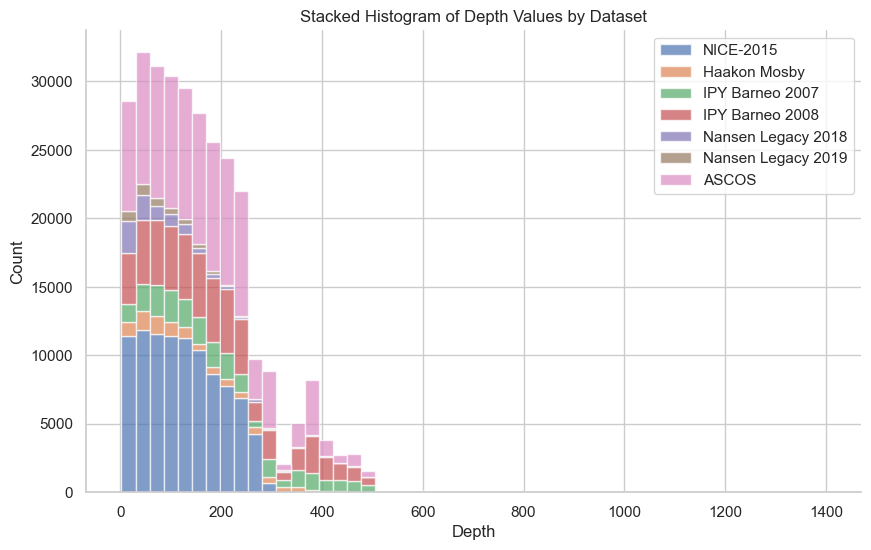

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up Seaborn style
sns.set(style='whitegrid')

# Define the depth values and cruise labels
depth_values = [full_df.loc[full_df['cruise'] == cruise, 'depth'] for cruise in full_df['cruise'].unique()]
labels = full_df['cruise'].unique()

# Plot a stacked histogram with labeled bars
plt.figure(figsize=(10, 6))
plt.hist(depth_values, bins=50, stacked=True, label=labels, alpha=0.7)

plt.xlabel('Depth')
plt.ylabel('Count')
plt.title('Stacked Histogram of Depth Values by Dataset')
plt.legend()

# Remove the right and top spines
sns.despine()

# Display the plot
plt.show()